In [2]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from transformers import TrainingArguments, Trainer
import torch

from introdl.utils import config_paths_keys

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys(env_path='../Course_Tools/mac.env')
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson
LESSON_DATA_PATH = Path('./data').resolve()
data_path = LESSON_DATA_PATH / 'IT_tickets_classify.csv'

In [9]:
# Helper Functions

def load_dataframe(data_path):
    """Load the dataframe from a CSV file."""
    return pd.read_csv(data_path)

def prepare_data(df, test_size=0.2, random_state=42):
    """Split data into train and test sets, and map labels to integers."""
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
    )

    # Map labels to integers
    unique_labels = list(set(train_labels + test_labels))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}
    id_to_label = {i: label for label, i in label_to_id.items()}

    train_labels = [label_to_id[label] for label in train_labels]
    test_labels = [label_to_id[label] for label in test_labels]

    return train_texts, test_texts, train_labels, test_labels, label_to_id, id_to_label

def visualize_data(df):
    """Visualize the data with barplots of percentages and boxplots of document lengths."""
    # Calculate percentages per category
    category_counts = df["Topic_group"].value_counts(normalize=True) * 100
    category_percentages = category_counts.reset_index()
    category_percentages.columns = ["Topic_group", "Percentage"]

    # Calculate lengths of documents
    df["Document_Length"] = df["Document"].apply(len)

    # Create the side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Barplot: Percentage per category
    sns.barplot(
        data=category_percentages,
        x="Percentage",
        y="Topic_group",
        palette="viridis",
        ax=axes[0]
    )
    axes[0].set_title("Percentage of Tickets per Category")
    axes[0].set_xlabel("Percentage")
    axes[0].set_ylabel("Topic Group")

    # Boxplot: Distribution of document lengths
    sns.boxplot(
        data=df,
        x="Document_Length",
        y="Topic_group",
        palette="viridis",
        ax=axes[1]
    )
    axes[1].set_title("Distribution of Document Lengths")
    axes[1].set_xlabel("Document Length")
    axes[1].set_ylabel("")

    # Set the suptitle
    fig.suptitle("Tickets", fontsize=16, weight="bold")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

def plot_confusion_matrix(y_true, y_pred, id_to_label, title="Confusion Matrix"):
    """Plot a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    labels = [id_to_label[i] for i in range(len(id_to_label))]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_20511/173716377.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_20511/173716377.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


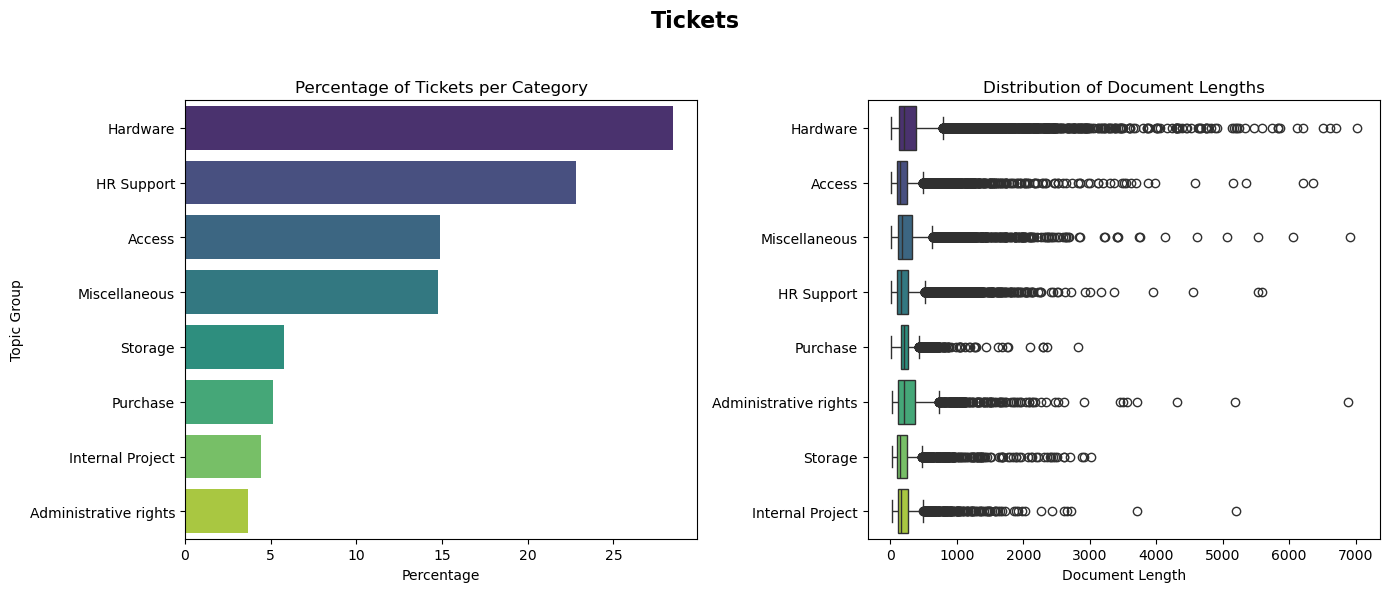

In [7]:
# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Paths and Data Preparation
data_path = "./data/IT_tickets_classify.csv"  # Replace with the actual path to your CSV
df = load_dataframe(data_path)
visualize_data(df)


In [10]:

train_texts, test_texts, train_labels, test_labels, label_to_id, id_to_label = prepare_data(df)


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

In [ ]:
import torch

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Feature Extraction with Frozen Model and XGBoost
def feature_extraction_and_xgboost():
    """Use a frozen DistilBERT model for feature extraction and train an XGBoost classifier."""
    model = AutoModel.from_pretrained(model_checkpoint).to(device)
    model.eval()  # Set model to evaluation mode

    def extract_features(texts):
        """Extract class token features."""
        inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token representation

    print("Extracting features from training data...")
    train_features = np.vstack([
        extract_features(train_texts[i:i + 16]) for i in range(0, len(train_texts), 16)
    ])

    print("Extracting features from testing data...")
    test_features = np.vstack([
        extract_features(test_texts[i:i + 16]) for i in range(0, len(test_texts), 16)
    ])

    print("Training XGBoost classifier...")
    # Train XGBoost Classifier
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    xgb_clf.fit(train_features, train_labels)

    print("Evaluating XGBoost classifier...")
    # Evaluate
    test_predictions = xgb_clf.predict(test_features)
    acc = accuracy_score(test_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average="weighted")
    print("XGBoost Metrics:", {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1})

    # Confusion Matrix
    plot_confusion_matrix(test_labels, test_predictions, id_to_label, title="Confusion Matrix - XGBoost")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [11]:
print("Running Feature Extraction with XGBoost Approach...")
xgboost_metrics = feature_extraction_and_xgboost()

Running Feature Extraction with XGBoost Approach...


KeyboardInterrupt: 

In [ ]:
# Tokenize datasets
tokenized_train = tokenize_dataset(tokenizer, train_texts, train_labels)
tokenized_test = tokenize_dataset(tokenizer, test_texts, test_labels)

def fine_tune_model():
    """Fine-tune the DistilBERT model and evaluate."""
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id)).to(device)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir="./logs",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=1,
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("Starting fine-tuning...")
    trainer.train()

    # Save the model to the specified path
    save_path = MODELS_PATH / 'distilbert_it_classify_finetuned.pth'
    print(f"Saving fine-tuned model to {save_path}...")
    torch.save(model.state_dict(), save_path)

    print("Evaluating fine-tuned model...")
    metrics = trainer.evaluate()
    print("Fine-Tuning Metrics:", metrics)

    # Predictions and Confusion Matrix
    print("Generating predictions...")
    predictions = trainer.predict(tokenized_test)
    plot_confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1), id_to_label, 
                          title="Confusion Matrix - Fine-Tuning")
    return metrics


print("\nRunning Fine-Tuning Approach...")
fine_tune_metrics = fine_tune_model()
